# Data Cleaning

This notebook contains the code used for cleaning the "HK_AirBnB_Data_raw.csv" data, exporting it into the "cleaned_HK_AirBnB_Data.csv".

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read the raw data
df = pd.read_csv(r"../dat/HK_AirBnB_Data_raw.csv")

In [3]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'number_of_reviews_ltm', 'license'],
      dtype='object')

In [4]:
len(df)

7029

In [5]:
df.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
count,7.029000e+03,7.029000e+03,0.0,7029.000000,7029.000000,6552.000000,7029.000000,7029.000000,3541.000000,7029.000000,7029.000000,7029.000000,0.0
mean,3.776090e+17,1.594925e+08,NaN,22.296967,114.163259,891.273657,20.400626,14.146251,0.888749,98.409020,216.688149,3.278133,NaN
std,4.403533e+17,1.778368e+08,NaN,0.034115,0.046004,2851.987331,42.007246,41.788835,1.146428,137.396629,146.416534,8.472504,NaN
min,1.789100e+04,6.303800e+04,NaN,22.191250,113.856340,1.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,NaN
25%,2.755237e+07,1.771335e+07,NaN,22.280540,114.155570,217.000000,1.000000,0.000000,0.140000,3.000000,69.000000,0.000000,NaN
50%,4.385338e+07,8.087394e+07,NaN,22.291929,114.171470,499.000000,7.000000,1.000000,0.450000,19.000000,263.000000,0.000000,NaN
75%,8.461219e+17,2.448217e+08,NaN,22.310550,114.180670,920.250000,29.000000,7.000000,1.150000,136.000000,364.000000,2.000000,NaN
max,1.049754e+18,5.510371e+08,NaN,22.547197,114.362470,150000.000000,1125.000000,511.000000,8.910000,398.000000,365.000000,119.000000,NaN


In [6]:
# drop columns since it has no/few values
df.drop(['neighbourhood_group', 'license', 'last_review', 'reviews_per_month'], axis=1, inplace=True)

In [7]:
# count of each room type
df['room_type'].value_counts()

Private room       3875
Entire home/apt    2747
Shared room         339
Hotel room           68
Name: room_type, dtype: int64

In [8]:
# one hot encode 'room_type' column
df = pd.get_dummies(df, columns=['room_type'])

In [9]:
# rename 'neighbourhood' into 'district'
df.rename(columns = {'neighbourhood': 'true_district'}, inplace = True)

In [10]:
# count all rows with atleast one missing value
df.isnull().sum()

id                                  0
name                                0
host_id                             0
host_name                           0
true_district                       0
latitude                            0
longitude                           0
price                             477
minimum_nights                      0
number_of_reviews                   0
calculated_host_listings_count      0
availability_365                    0
number_of_reviews_ltm               0
room_type_Entire home/apt           0
room_type_Hotel room                0
room_type_Private room              0
room_type_Shared room               0
dtype: int64

In [11]:
def split_name(text):
    elements = re.split(r'\s*·\s*★?|\s*·\s*', text)
    return elements

def extract_last_element(series):
    return series.apply(lambda x: x[-1] if isinstance(x, list) and len(x) > 0 else None)

def extract_second_last_element(series):
    return series.apply(lambda x: x[-2] if isinstance(x, list) and len(x) > 1 else None)

def extract_third_last_element(series):
    return series.apply(lambda x: x[-3] if isinstance(x, list) and len(x) > 2 else None)

def extract_first_element(series):
    return series.apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

def extract_second_element(series):
    return series.apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)

In [12]:
import re
df['name_temp'] = df['name'].apply(split_name)

df['num_baths'] = extract_last_element(df['name_temp'])
df['num_beds'] = extract_second_last_element(df['name_temp'])
df['num_bedrooms'] = extract_third_last_element(df['name_temp'])
df['name'] = extract_first_element(df['name_temp'])
df['rating'] = extract_second_element(df['name_temp'])


In [13]:
# list of allowed bedroom counts
allowed_bedroom_counts = [
    "1 bedroom",
    "Studio",
    "2 bedrooms",
    "3 bedrooms",
    "4 bedrooms",
    "5 bedrooms",
    "6 bedrooms",
    "9 bedrooms",
    "7 bedrooms",
    "10 bedrooms",
    "8 bedrooms",
    "11 bedrooms"
]

# filter the df to keep only rows with 'num_bedrooms' in the allowed list
df = df[df['num_bedrooms'].isin(allowed_bedroom_counts)]

In [14]:
df['bedroom_count'] = df['num_bedrooms'].replace('Studio', '0').str.extract('(\d+)').astype(int)

allowed_bedroom_counts = list(range(0, 12)) 

df = df[df['bedroom_count'].isin(allowed_bedroom_counts)]

df.drop(['num_bedrooms'], axis=1, inplace=True)

In [15]:
df['bathroom_count'] = df['num_baths'].str.replace('(?i)half-bath', '0.5', regex=True)

df['bathroom_count'] = df['bathroom_count'].str.extract('(\d+\.?\d*)').astype(float)

allowed_bathroom_counts = np.arange(0, 12, 0.5)

df = df[df['bathroom_count'].isin(allowed_bathroom_counts)]

In [16]:
df.drop(['num_baths'], axis=1, inplace=True)

In [17]:
df['num_beds'].value_counts()

1 bed      4809
2 beds     1145
3 beds      408
4 beds      248
5 beds       81
6 beds       59
8 beds       46
10 beds      21
7 beds       17
9 beds       12
16 beds      11
11 beds       8
14 beds       1
15 beds       1
12 beds       1
13 beds       1
Name: num_beds, dtype: int64

In [18]:
df['bed_count'] = df['num_beds'].str.extract('(\d+)').astype(int)

allowed_bedroom_counts = list(range(0, 16))

df = df[df['bed_count'].isin(allowed_bedroom_counts)]

df.drop(['num_beds'], axis=1, inplace=True)

In [19]:
df.drop(['rating'], axis=1, inplace=True)

In [20]:
df.drop(['name_temp'], axis=1, inplace=True)

In [21]:
# one hot encode True_district
df = pd.get_dummies(df, columns=['true_district'])

In [22]:
# drop rows where price is missing
df = df.dropna(subset=['price'])

In [23]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,...,true_district_Sha Tin,true_district_Sham Shui Po,true_district_Southern,true_district_Tai Po,true_district_Tsuen Wan,true_district_Tuen Mun,true_district_Wan Chai,true_district_Wong Tai Sin,true_district_Yau Tsim Mong,true_district_Yuen Long
count,6.390000e+03,6.390000e+03,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,...,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000
mean,3.890393e+17,1.637249e+08,22.296732,114.163852,889.114867,20.206260,14.428482,102.899374,232.121283,3.471362,...,0.007981,0.024570,0.022535,0.004538,0.002973,0.004695,0.225352,0.003443,0.372770,0.007042
std,4.428073e+17,1.802190e+08,0.033145,0.045605,2868.029102,37.116194,42.620326,138.680579,139.234947,8.768070,...,0.088987,0.154822,0.148428,0.067219,0.054452,0.068363,0.417847,0.058580,0.483579,0.083629
min,7.257100e+04,6.303800e+04,22.191250,113.856340,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.743793e+07,1.825362e+07,22.280494,114.159905,217.000000,1.000000,0.000000,4.000000,90.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.404442e+07,9.447404e+07,22.292145,114.171620,500.000000,12.500000,0.000000,22.000000,271.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.520037e+17,2.524692e+08,22.310853,114.180737,925.000000,29.000000,7.000000,136.000000,364.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.049754e+18,5.510371e+08,22.547197,114.362470,150000.000000,365.000000,511.000000,398.000000,365.000000,119.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# export df
df.to_csv('cleaned_HK_AirBnB_Data.csv', index=False)

# Modeling

In [25]:
# pcr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from ISLP.models import ModelSpec as MS
import sklearn.linear_model as skl
import sklearn.model_selection as skm


df = pd.read_csv('cleaned_HK_AirBnB_Data.csv')

In [28]:
df.drop(['id', 'name', 'host_id', 'host_name'], axis=1, inplace=True)

In [29]:
design = MS(df.columns.drop('price')).fit(df)
X = np.asarray(design.fit_transform(df).drop('intercept', axis=1))
Y = np.array(df['price'])

In [30]:
print(design)

ModelSpec(terms=Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bedroom_count', 'bathroom_count', 'bed_count',
       'true_district_Central & Western', 'true_district_Eas...
       'true_district_Kwai Tsing', 'true_district_Kwun Tong',
       'true_district_North', 'true_district_Sai Kung',
       'true_district_Sha Tin', 'true_district_Sham Shui Po',
       'true_district_Southern', 'true_district_Tai Po',
       'true_district_Tsuen Wan', 'true_district_Tuen Mun',
       'true_district_Wan Chai', 'true_district_Wong Tai Sin',
       'true_district_Yau Tsim Mong', 'true_district_Yuen Long'],
      dtype='object'))


# CV

In [31]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)

In [32]:
pca = PCA(n_components=2) 
linreg = skl.LinearRegression()
scaler = StandardScaler(with_mean = True, with_std = True)
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([292.73267842, -40.26407713])

In [33]:
param_grid = {'pca__n_components': range(1, 20)} 
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

In [34]:
from matplotlib.pyplot import subplots


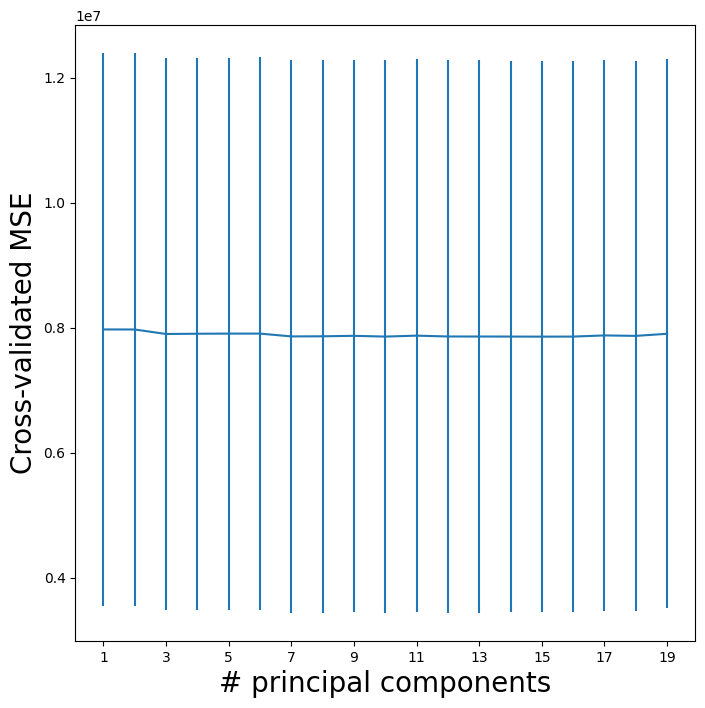

In [35]:
pcr_fig, ax = subplots(figsize=(8,8)) 
n_comp = param_grid['pca__n_components'] 
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K)) 
ax.set_ylabel('Cross-validated MSE', fontsize=20) 
ax.set_xlabel('# principal components', fontsize=20) 
ax.set_xticks(n_comp[::2])

In [36]:
# print the best number of components
print(grid.best_params_)

{'pca__n_components': 15}


In [37]:
Xn = np.zeros((X.shape[0], 1)) 
cv_null = skm.cross_validate(linreg,
                             Xn,
                             Y,
                             cv=kfold, scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

8228359.060269619

In [38]:
print(len(df.columns))

33


In [39]:
pca_components = pipe.named_steps['pca'].components_
linreg_coefficients = pipe.named_steps['linreg'].coef_

feature_contributions = np.dot(pca_components.T, linreg_coefficients)

feature_importance_ranking = np.argsort(np.abs(feature_contributions))[::-1]

print("Most Important Features by Contribution to Model:")
# print first 12 most important features
for rank in feature_importance_ranking[:12]:
    print(df.columns[rank], feature_contributions[rank])

Most Important Features by Contribution to Model:
room_type_Hotel room -119.10367110822502
number_of_reviews_ltm 115.39225299718386
number_of_reviews -113.24525702649431
bathroom_count 86.80921026893668
true_district_Eastern 83.33099313302063
calculated_host_listings_count -83.11442992123183
longitude -82.52238533287543
availability_365 66.41285152715491
minimum_nights 61.98352179826867
room_type_Shared room 59.071940558189745
bedroom_count 51.478616064443194
true_district_Tuen Mun -33.89224278538341


# Ridge

In [40]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# split a X and y test and train
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Elastic Net model
elastic_net = ElasticNet(random_state=0)

# Define the parameter grid to search over
param_grid_en = {
    'alpha': [0.1, 1, 10, 100], # You might need to adjust these values
    'l1_ratio': np.arange(0.0, 1.0, 0.1) # Adjusting the mix ratio
}

# Setup Grid Search with Cross-Validation
grid_search_en = GridSearchCV(estimator=elastic_net, param_grid=param_grid_en, cv=kfold, scoring='neg_mean_squared_error')

# Fit the model
grid_search_en.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_en.best_params_)

# Optionally, you can inspect the coefficients of the model
best_en_model = grid_search_en.best_estimator_
print("Coefficients of the best model:", best_en_model.coef_)

# Determine the most important features
feature_importance = np.abs(best_en_model.coef_)
important_features = np.argsort(feature_importance)[::-1]

print("Most Important Features by Elastic Net Model:")
for i in important_features[:12]: # Adjust the number to your preference
    print(df.columns[i], feature_importance[i])


C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e+10, tolerance: 4.340e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\mccao\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+10, tolerance: 2.719e+06 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

Best parameters found:  {'alpha': 0.1, 'l1_ratio': 0.1}
Coefficients of the best model: [-1.38886508e+01 -8.07858595e+00  7.56435539e-01  1.35249460e-01
 -2.85235777e+00  4.40299089e-01 -1.30849892e+01  2.27132932e+02
 -2.19765113e+01 -1.65679637e+02 -3.92544861e+01  2.13583180e+02
  1.75776526e+02  9.86532457e+01  1.97818785e+02 -1.41587530e+01
 -4.66610552e+01 -3.84696147e+01 -3.45439585e+00  1.41823856e+01
  5.04422024e+00 -1.87968919e+01 -3.28243061e+01 -6.02232905e+01
  1.49083552e+02 -2.08025224e+01  1.80041712e+02 -2.17396936e+01
 -1.26736626e+02  3.58303078e+00 -1.39131648e+02 -2.60882006e+01]
Most Important Features by Elastic Net Model:
number_of_reviews_ltm 227.13293247358587
room_type_Shared room 213.5831796092363
bed_count 197.81878491635325
true_district_Tai Po 180.0417121804781
bedroom_count 175.77652638316084
room_type_Hotel room 165.67963693122408
true_district_Sham Shui Po 149.08355151364273
true_district_Wong Tai Sin 139.13164809538515
true_district_Tuen Mun 126.7366

In [41]:
# print the mse
y_pred = grid_search_en.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

MSE:  792648.2685747537


In [42]:
# split a X and y test and train
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('regressor', LinearRegression())
])

# create a grid search
param_grid = {
    'pca__n_components': range(1, X.shape[1]+1),
}

grid = skm.GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

# print the best parameters
print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

{'pca__n_components': 7}
0.07641837382251015
0.2959597754353608


In [43]:
# print mse
y_pred = grid.predict(X_test)
print(mean_squared_error(y_test, y_pred))

765118.5551152095
